***
### __Darius Petermann, Ana Pandrea__ <br>
Emails: <dariusarthur.petermann01@estudiant.upf.edu>, <anagabriela.pandrea01@estudiant.upf.edu> <br>
Project Git Page: https://github.com/darius522/satb-voice-estimate.git
#### Companion Code for the Paper: <br>  
*__"Cadential-Based Feature for Automatic Maqam Detection"__*
***

How this notebook works:

This notebook is divided into three main sections:

* 1. [Set-up and Pre-processing Steps](#part1): First we go through the generic set-up steps such as data handling, formatting, pre-processing:
    1. [Maqam Sorting and Selection](#part11):
    2. [Remove Key Signatures from Scores](#part12)
* 2. [Approach 1: Consider Every Degree Occurence](#part2): MFC's: We then dive into the first part of our experiment, which is the computation of our baseline using MFC's:
    1. [Retrieve Key Scale-Degrees for Each Makam](#part21)
    2. [Compute the Statistics / Plot the Results](#part22)
* 3. [Approach 2: Consider Only Degree Occurring on Usul Beats](#part3): In the second part of our experiment, we use the deep salience framework (cited later), in order to improve upon our initial baseline:
    1. [Usul Sorting and Selection](#part31)
    2. [Usul Beat Definitions](#part32)
    3. [Process the Scores](#part33)
    4. [Compute the Statistics / Plot the Results](#part34)

In [1]:
from music21 import *
import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
import numpy as np
import collections
import copy

In [2]:
# Define local path to Music XML dataset 
score_path = './MusicXML'

<a id='part1'></a>
<h1><center>Set-up and Pre-processing Steps</center></h1>
The naming convention of the xml files in the SymbTr collection is as follows:

`makam--form--usul--lyrics--composer.xml`
***
<a id='part11'></a>
### 1. Maqam Sorting and Selection:

We sort the Makam by their numbers of scores available and take the first **10** ones.

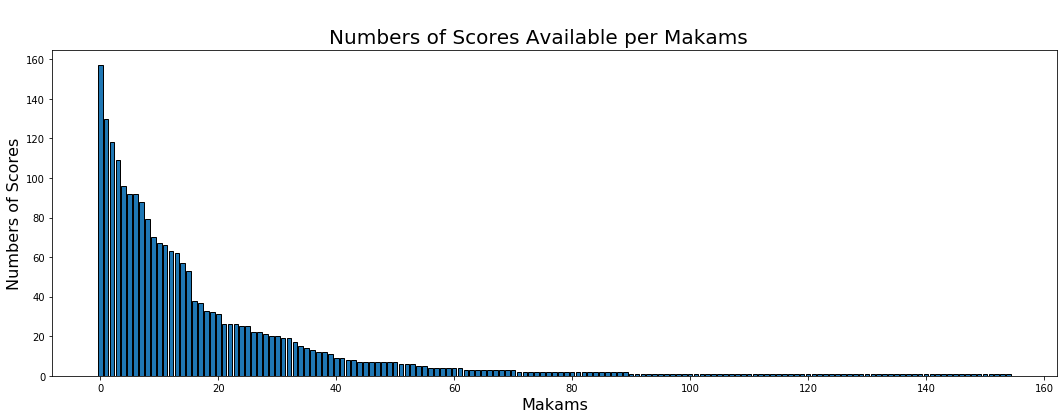

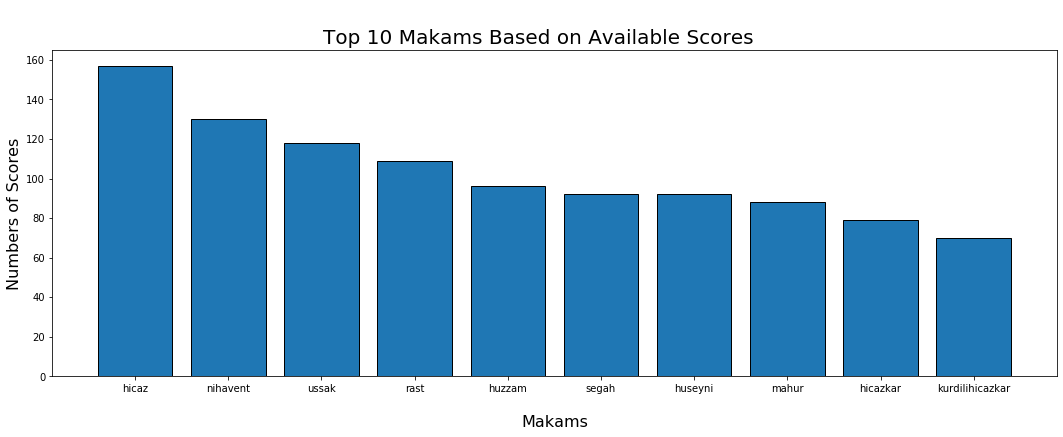

In [3]:
allScores = os.listdir(score_path)

scoresByMakams = {}
scoresByUsuls   = {}

for score in allScores:
    if score.endswith('xml'):
        makam = score.split('--')[0]
        usul  = score.split('--')[2]
        
        if makam in scoresByMakams:
            scoresByMakams[makam].append(score)
        else:
            scoresByMakams[makam] = [score]
            
        # Used in approach#2 later   
        if usul in scoresByUsuls:
            scoresByUsuls[usul].append(score)
        else:
            scoresByUsuls[usul] = [score]

# Sort the makams per numbers of scores available
num_scores_per_makam = []
top_makams = [] # Holds the makams in order of their available scores, descendingly.
for k in sorted(scoresByMakams, key=lambda k: len(scoresByMakams[k]), reverse=True):
    num_scores_per_makam.append(len(scoresByMakams[k]))
    top_makams.append(k)

# Plot the numbers of scores per makams
f1, ax1 = plt.subplots(figsize=(18,6))
plt.bar(range(len(num_scores_per_makam)), num_scores_per_makam, color='tab:blue', edgecolor='black')
f1.suptitle('\nNumbers of Scores Available per Makams', fontsize=20)
plt.xlabel('Makams', fontsize=16)
plt.ylabel('Numbers of Scores', fontsize=16)
plt.show()

# Only plot the numbers of scores per top makams (total = 10)
f2, ax2 = plt.subplots(figsize=(18,6))
plt.bar(range(10), num_scores_per_makam[:10], color='tab:blue', edgecolor='black', tick_label=top_makams[:10])
f2.suptitle('\nTop 10 Makams Based on Available Scores', fontsize=20)
plt.xlabel('\nMakams', fontsize=16)
plt.ylabel('Numbers of Scores', fontsize=16)
plt.show()

Now that we're clear on what scores we want to work with, we will have to:
* Remove the key signature from these score
* Rewrite all the scores and places then in a well formatted folder structure (each subfolder represent a makam)

**Notes:** If the folder mentioned below exist, this cell will simply be ignored

***
<a id='part12'></a>
### 2. Remove Key Signatures from Scores

In [4]:
new_score_folder = score_path+'_WithoutKeySignature'
if not os.path.isdir(new_score_folder):
    os.mkdir(new_score_folder)
    for makam in top_makams[:10]:
        print('Processing '+makam+' scores...')
        makamDir = new_score_folder+'/'+makam
        os.mkdir(makamDir)
        for makamScore in scoresByMakams[makam]:

            # Remove the key signature from the xml file
            tree = ET.parse(os.path.join(score_path, makamScore))
            root = tree.getroot()

            for k in root.iter('key'):
                for ks in k.findall('key-step'):
                    k.remove(ks)
                for ka in k.findall('key-accidental'):
                    k.remove(ka)
                for ka in k.findall('key-alter'):
                    k.remove(ka)

            # Save the new xml files to be later loaded with music21
            newMakamScore = os.path.join(makamDir, makamScore[:-4] + '_withoutKeySignature.xml')
            tree.write(newMakamScore)
    print('Done!')
else:
    print('The folder with the new scores already exists at: '+new_score_folder)

The folder with the new scores already exists at: ./MusicXML_WithoutKeySignature


<a id='part2'></a>
***
<h1><center>Score Analysis</center></h1>
<h2><center>Approach 1: Consider Every Degree Occurence</center></h2>

***

<a id='part21'></a>
***
### 1. Define Key Scale-Degrees for Each Makam

Before actually proceeding in seeking the Makam key degree in their respective score, we need to know what notes we are actually looking for. In this view, we will set up a dictionary containing the 10 makams as key and their respective key scale degrees as values:

In [5]:
# In the following order: Tonic, Dominant, Leading tone
degrees_for_makams = dict({'hicaz':['A4','D5','G5'],
                           'nihavent':['G4','D5','F#5'],
                           'ussak':['A4','D5','G4'],
                           'rast':['G4','D5','F#4'], # low f
                           'huzzam':['B`4','D5','A5'], # 
                           'segah':['B`4','D5','A#5'], # 
                           'huseyni':['A4','E5','G5'],
                           'mahur':['G5','D5','F5'], #
                           'hicazkar':['G5','D5','F#5'], # 
                           'kurdilihicazkar':['G5','C5','F5']})# G is primary dom.

<a id='part22'></a>
***
### 2. Process the Scores

In [15]:
from tqdm.notebook import tqdm
from time import sleep

adjacent = dict({'left':[],'right':[]})
adjacents_notes_tonic = {key:copy.deepcopy(adjacent) for key in top_makams[:10]}
adjacents_notes_domin = {key:copy.deepcopy(adjacent) for key in top_makams[:10]}
adjacents_notes_leadt = {key:copy.deepcopy(adjacent) for key in top_makams[:10]}

for root, dirs, files in os.walk(new_score_folder):
    
    current_makam_folder = root.split('/')[-1]
    notes = dict()
    
    if not current_makam_folder == new_score_folder.split('/')[-1]:
        print('Processing '+current_makam_folder+' makam scores...')
        sleep(1.0)
        current_makam_degrees = degrees_for_makams[current_makam_folder]
        for file in tqdm(files):
            if file.endswith('xml'):
                filepath = os.path.abspath(('{}/{}'.format(root,file)))
                s = converter.parse(filepath)
                nn = s.parts[0].flat.notes.stream()
                for idx, n in enumerate(nn):
                    
                    # Format the name with the octave
                    note_name = n.name + str(n.octave)
                    
                    if note_name not in notes.keys():
                        notes[note_name] = 1
                    else:
                        notes[note_name] += 1  
                    # If == TONIC
                    if note_name == current_makam_degrees[0]:
                        if not idx == 0:
                            adjacents_notes_tonic[current_makam_folder]['left'].append(nn[idx-1].name+str(nn[idx-1].octave))
                        if not idx >= len(nn)-1:
                            adjacents_notes_tonic[current_makam_folder]['right'].append(nn[idx+1].name+str(nn[idx+1].octave))
                    # If == DOMINANT
                    elif note_name == current_makam_degrees[1]:
                        if not idx == 0:
                            adjacents_notes_domin[current_makam_folder]['left'].append(nn[idx-1].name+str(nn[idx-1].octave))
                        if not idx >= len(nn)-1:
                            adjacents_notes_domin[current_makam_folder]['right'].append(nn[idx+1].name+str(nn[idx+1].octave))
                    # If == LEADING TONE
                    elif note_name == current_makam_degrees[2]:
                        if not idx == 0:
                            adjacents_notes_leadt[current_makam_folder]['left'].append(nn[idx-1].name+str(nn[idx-1].octave))
                        if not idx >= len(nn)-1:
                            adjacents_notes_leadt[current_makam_folder]['right'].append(nn[idx+1].name+str(nn[idx+1].octave))
                            
                        
print('\nFinished Processing Scores!\n')


Processing hicaz makam scores...



Processing mahur makam scores...



Processing ussak makam scores...



Processing nihavent makam scores...



Processing kurdilihicazkar makam scores...



Processing hicazkar makam scores...



Processing huzzam makam scores...



Processing segah makam scores...



Processing rast makam scores...



Processing huseyni makam scores...




Finished Processing Scores!



<a id='part23'></a>
***
### 3. Compute the Statistics / Plot the Results

Once we've retrieved right/left adjacent notes for __ALL__ scale degree occurrence (approach#1), we can actually compute the occurrence statistics by using the convenient ```Counter``` Class from the ```collections``` python package. By doing so, we will know for each makam what are the most recurrent adjacent notes for each scale degree (__tonic, dominant, leading tone__).

In [16]:
from collections import Counter

def autolabel(rects,labels,gaps,ax):
    # attach some text labels
    for idx,rect in enumerate(rects):
        height = rect.get_height()
        label  = labels[idx]
        gap    = float("{0:.1f}".format(gaps[idx]))
        s      = str(label+'\n'+str(gap))
        props  = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(rect.get_x() + rect.get_width()/2., 
                height+0.06,
                s = s,
                size = 16,
                bbox=props,
                ha='center', va='bottom', weight='bold')

def plotAdjacentNotesPerMakam(adjacent_notes=[],titles=[],save_name = ''):
    for idx, adjacent_array in enumerate(adjacent_notes):

        rights = []
        lefts  = []
        makams = []
        gaps_right   = []
        gaps_left    = []
        title  = titles[idx]

        for makam in adjacent_array.keys():    

            # Storing all stats for later plotting
            makams.append(makam)
            two_most_cmn_left = Counter(adjacent_array[makam]['left']).most_common(2)
            two_most_cmn_right = Counter(adjacent_array[makam]['right']).most_common(2)
            
            lefts.append(two_most_cmn_left[0][0])
            rights.append(two_most_cmn_right[0][0])
            
            gaps_right.append((two_most_cmn_right[0][1] / two_most_cmn_right[1][1]) - 1.0)
            gaps_left.append((two_most_cmn_left[0][1] / two_most_cmn_left[1][1]) - 1.0)

        ind = np.arange(10)
        plt.rc('xtick', labelsize=16)
        plt.rc('ytick', labelsize=16)
        f, ax = plt.subplots(figsize=(18,6))
        #f.suptitle(title, fontsize=20)
        p1 = ax.bar(ind, lefts, 0.40,color = (0.3,0.5,0.4,0.6), edgecolor='black', tick_label=makams)
        p2 = ax.bar(ind+0.4, rights, 0.40,color = (0.3,0.9,0.4,0.6), edgecolor='black', tick_label=makams)
        ax.legend((p1[0], p2[0]), ('Left', 'Right'),loc='upper left',prop={'size': 15})
        ax.set_ylim((-1, ''))
        autolabel(p1,lefts,gaps_left,ax)
        autolabel(p2,rights,gaps_right,ax)
        plt.tight_layout()
        if not save_name == '':
            plt.savefig(save_name+title+'.png')
        plt.show()
        


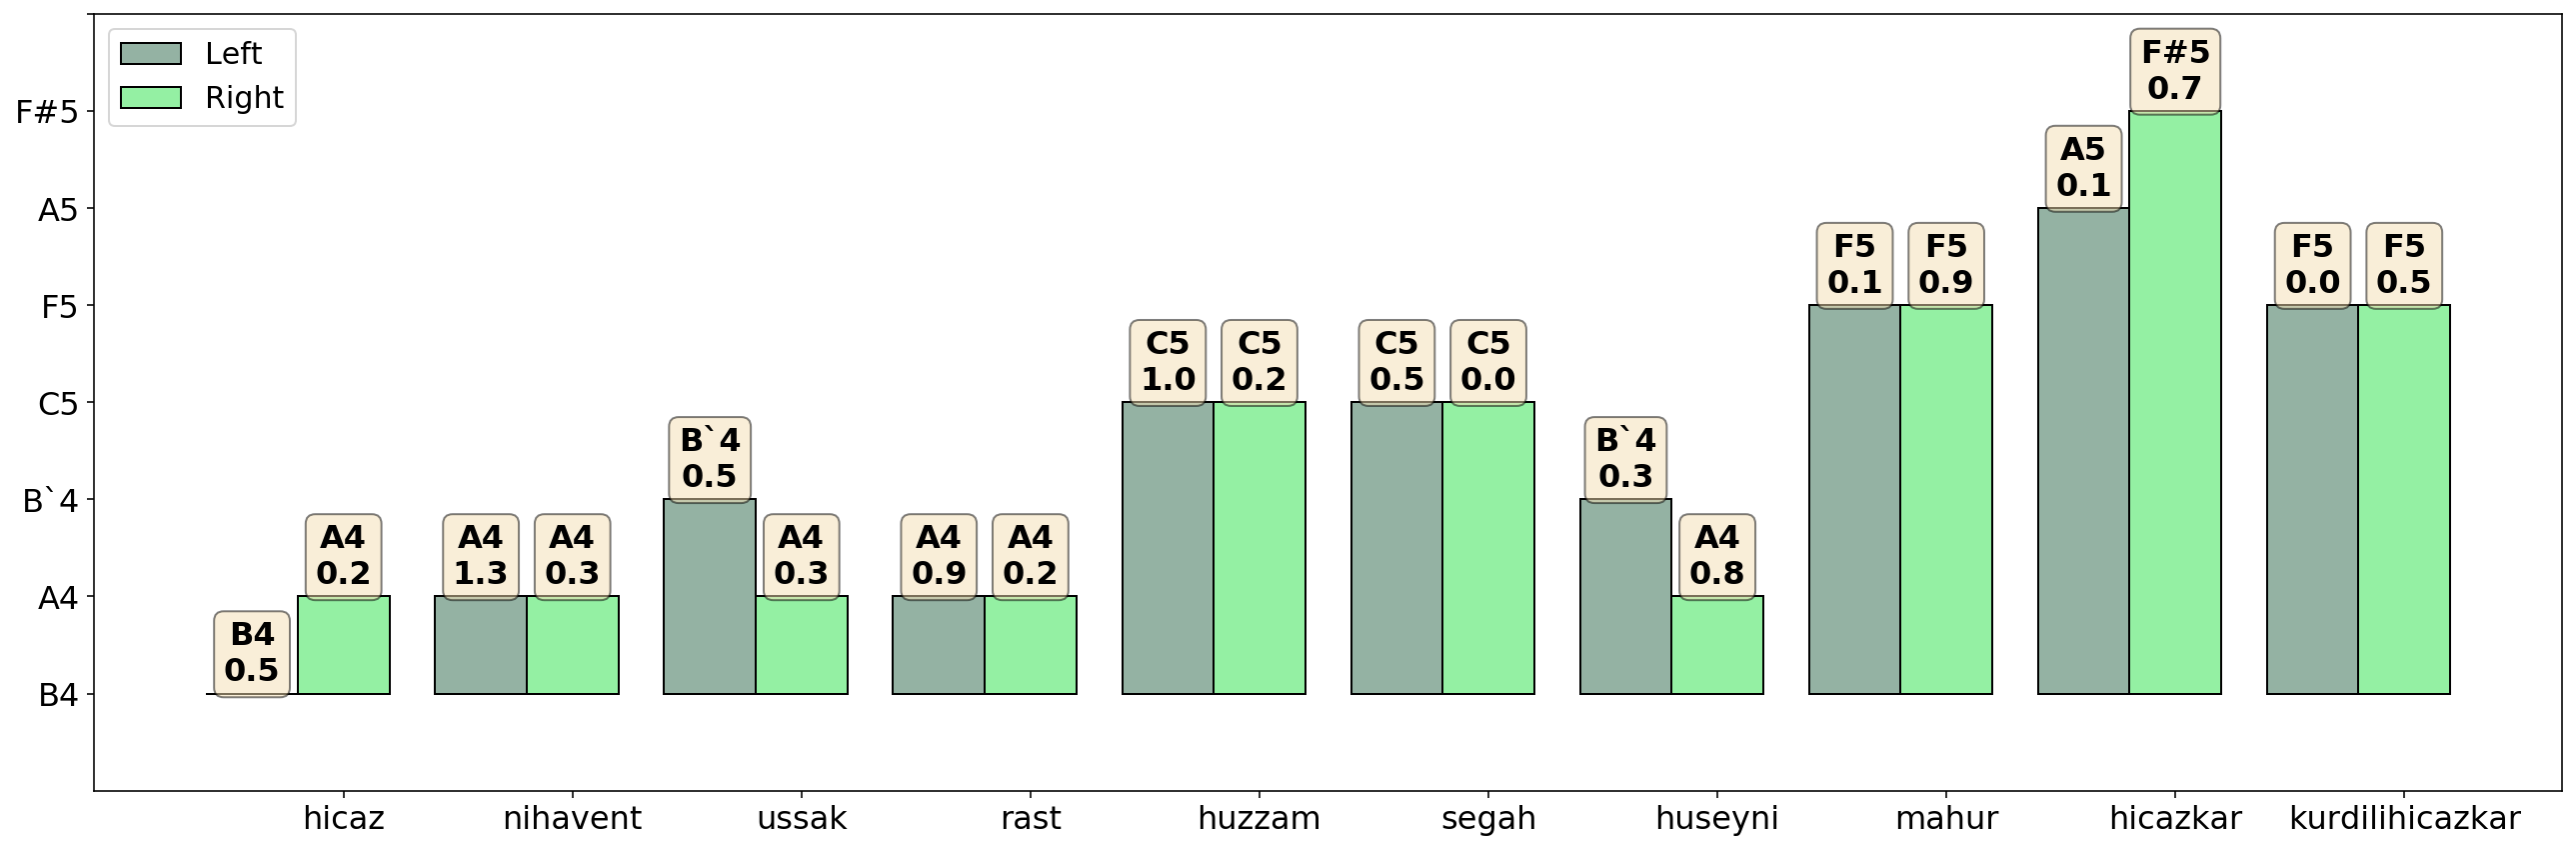

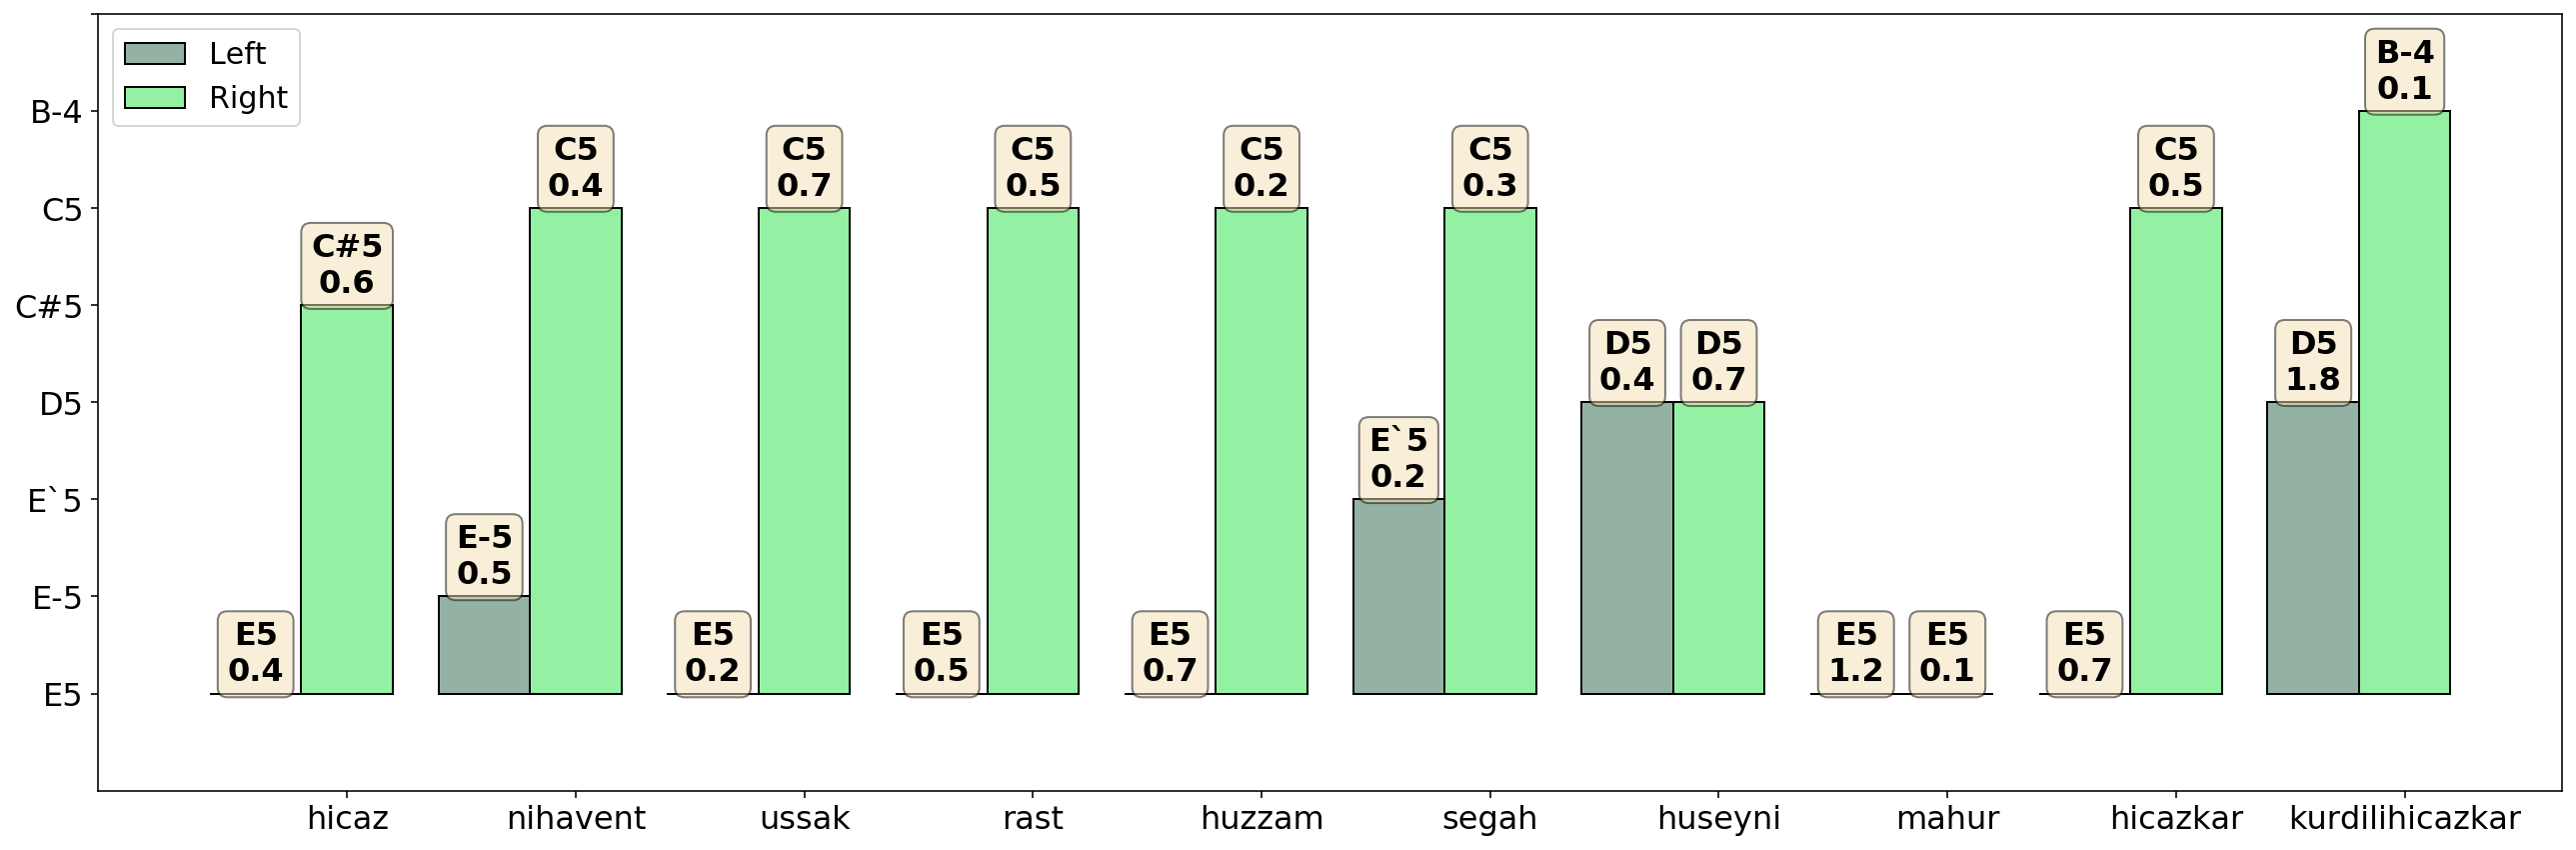

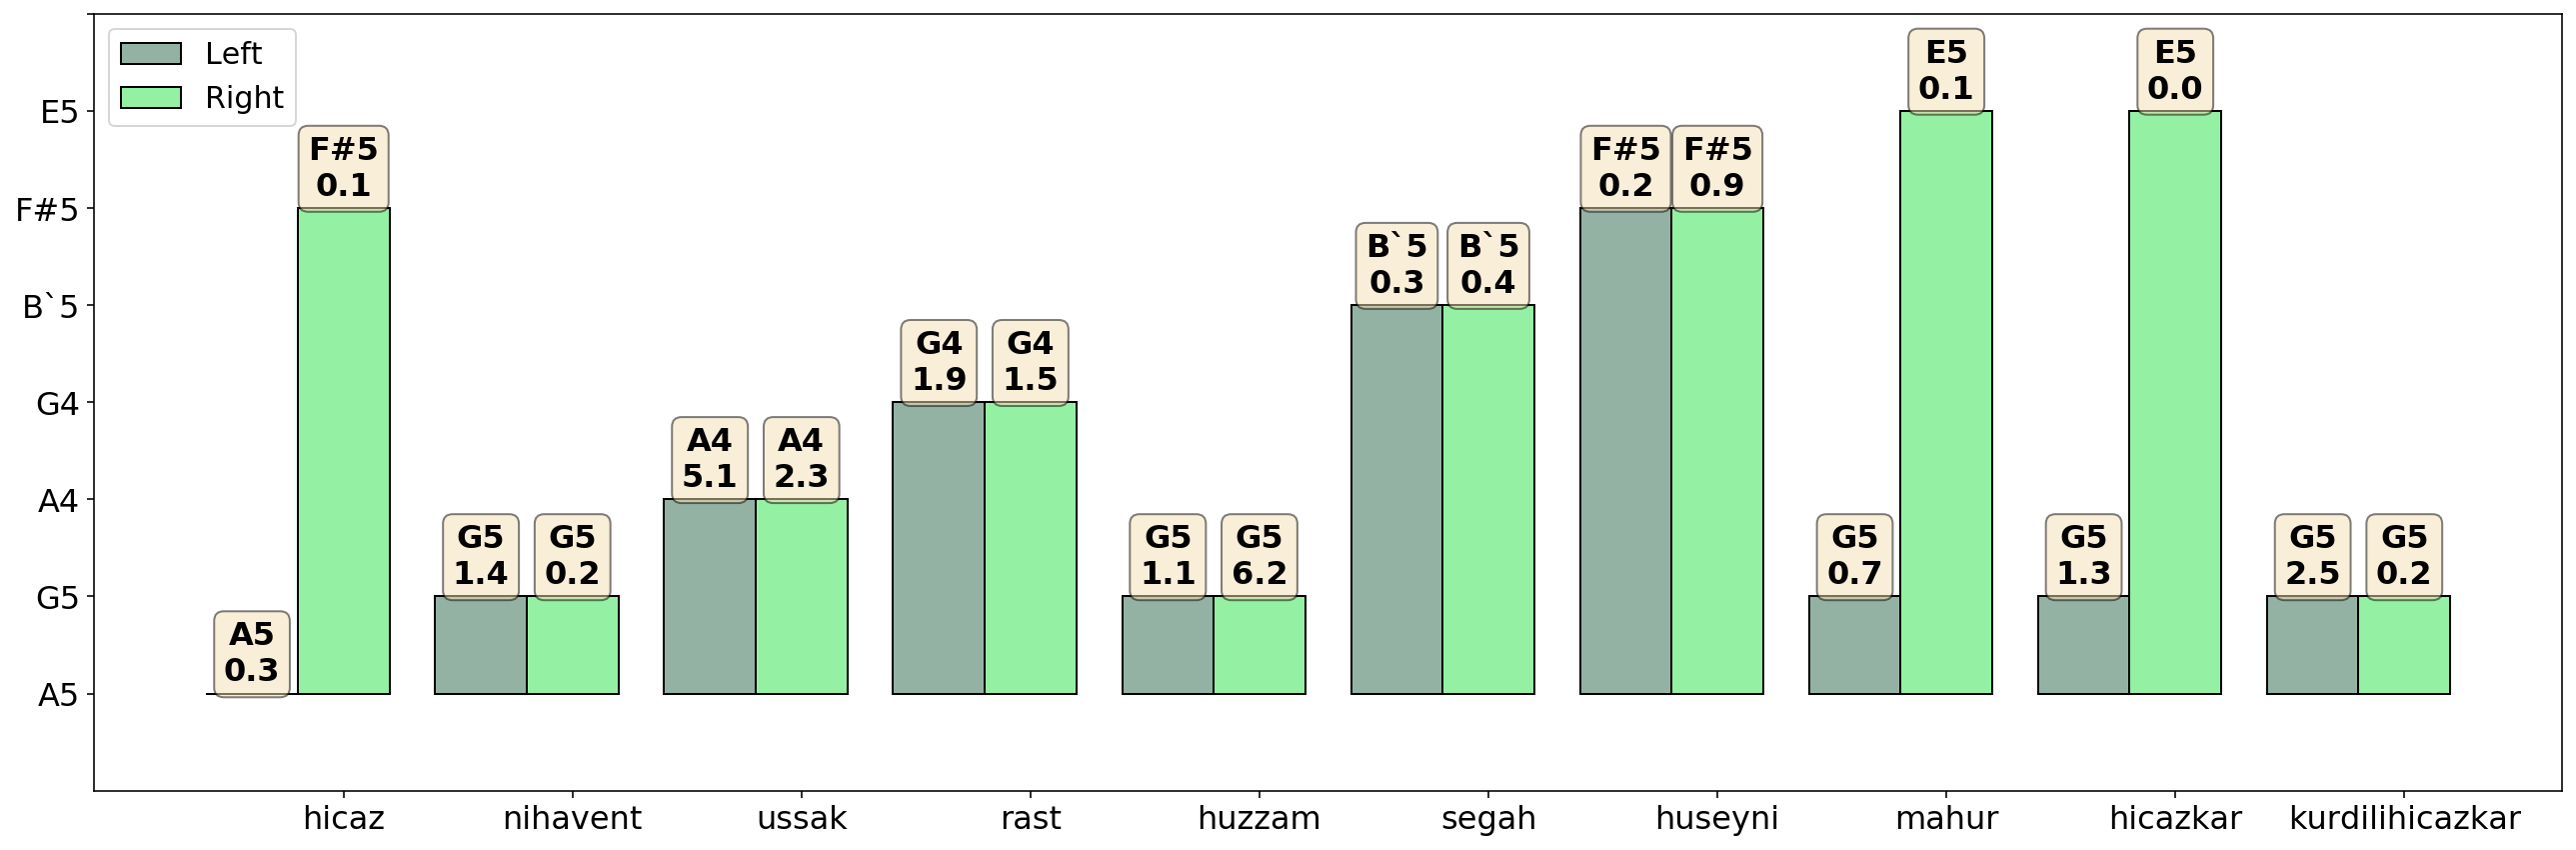

In [17]:
adjacent_notes = [adjacents_notes_tonic,adjacents_notes_domin,adjacents_notes_leadt]
titles = ['\nAdjacent Notes To Tonic for Makams',
          '\nAdjacent Notes To Dominant for Makams',
          '\nAdjacent Notes To Leading Tone for Makams']
plotAdjacentNotesPerMakam(adjacent_notes,titles,save_name='./approach1_')

<a id='part3'></a>
***
<h2><center>Approach 2: Consider Only Degree Occurring on Usul Beat</center></h2>

***
### 1. Usul Sorting and Selection
Since our experiment doesn´t target usul analysis, we could simply take into account all usul for this experiment. However, proceeding that way would entail a substantial effort on the implementation side, which we don't judge necessary here. Consequently we opt to pick only the top three usul.

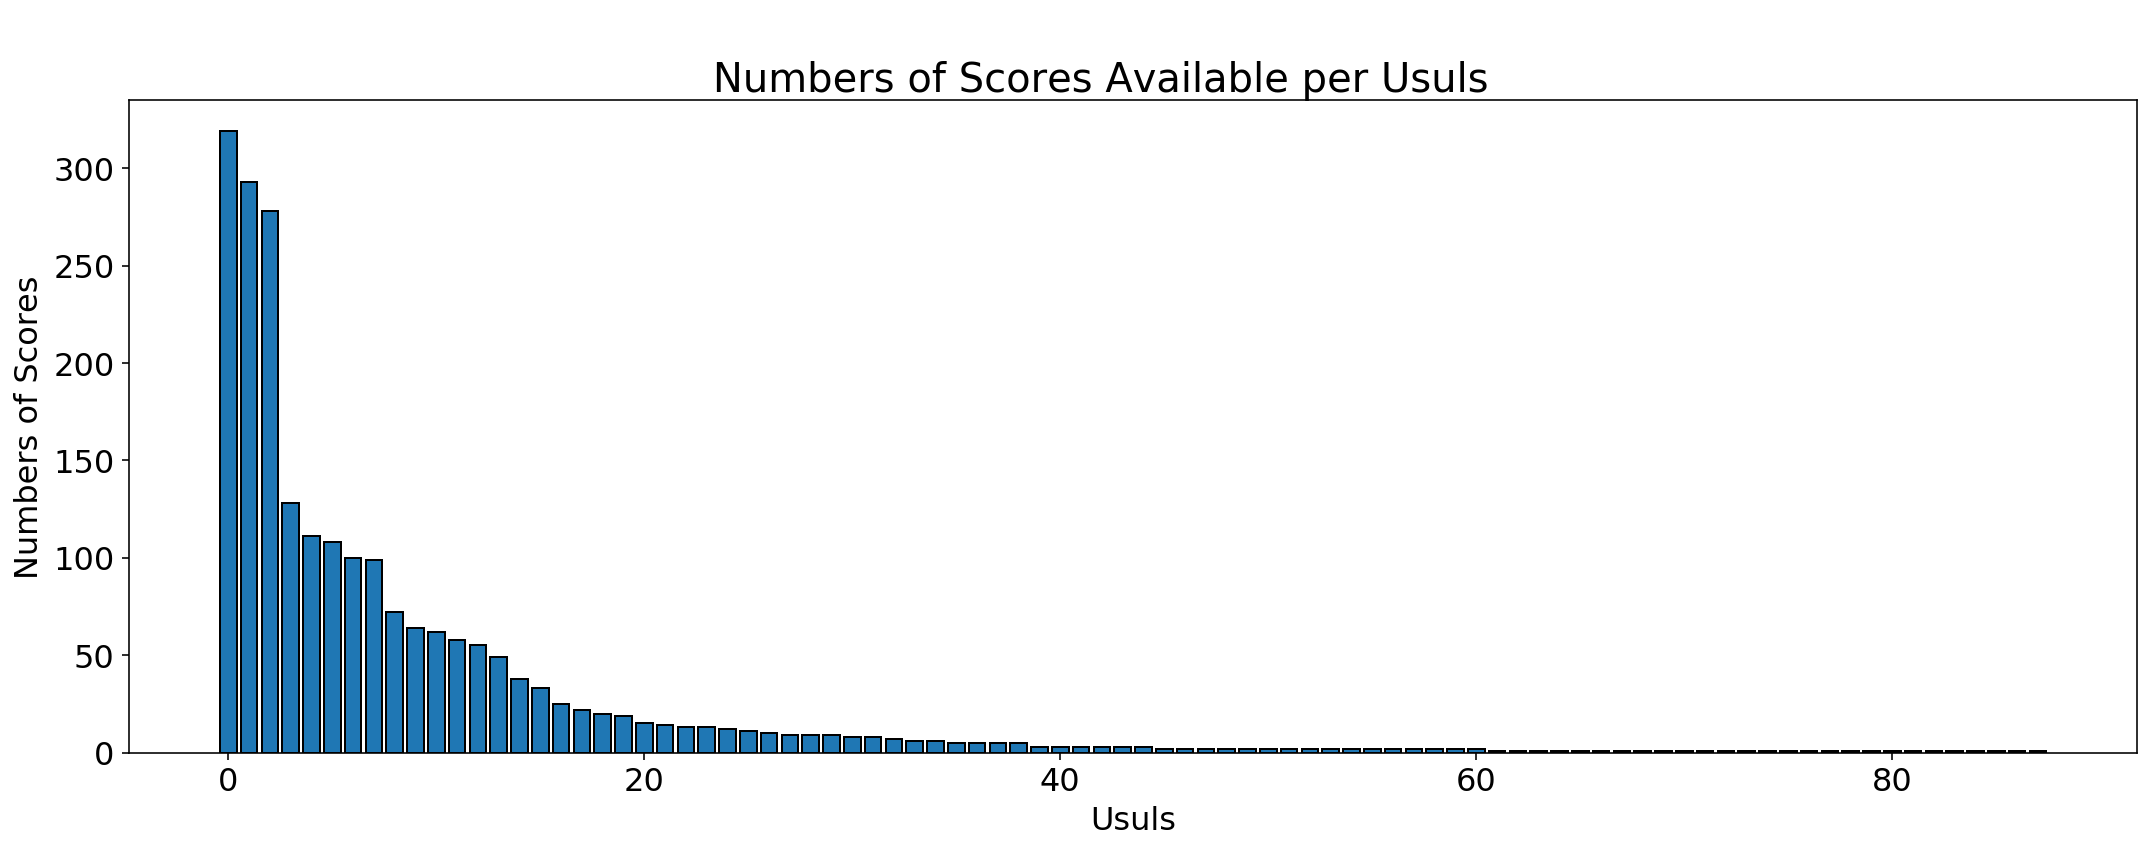

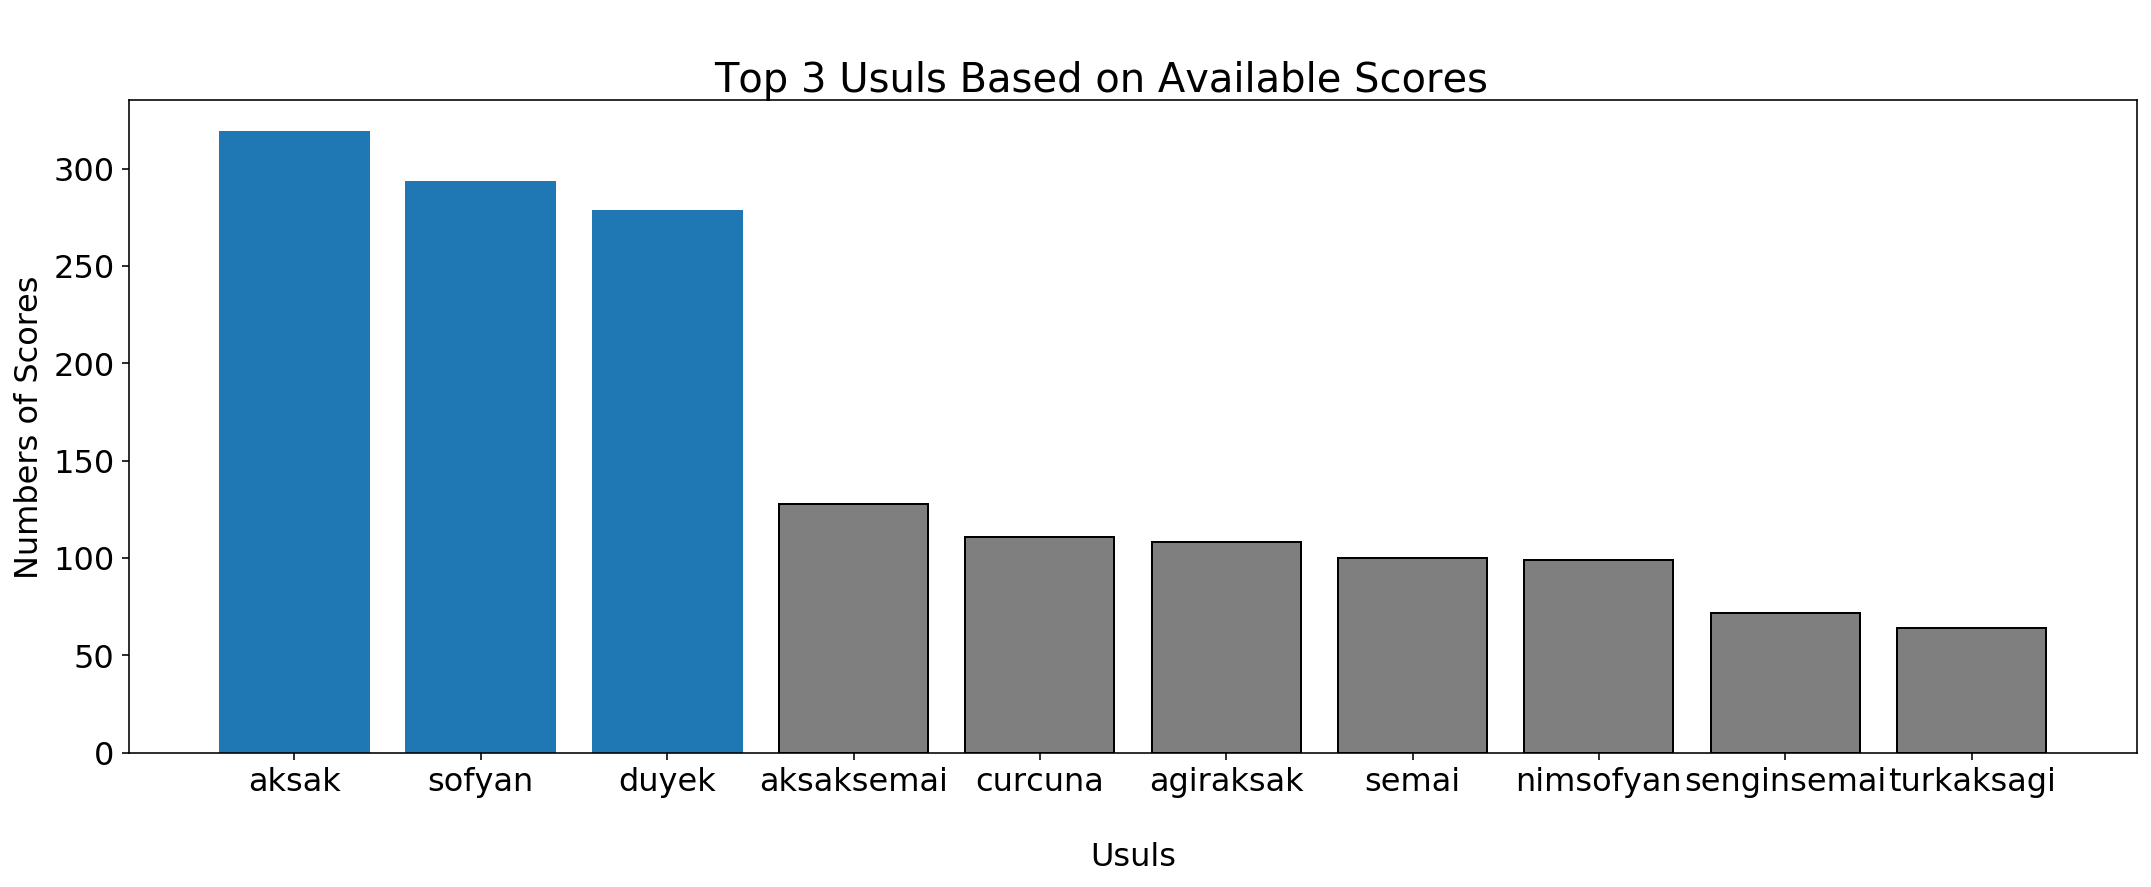

In [18]:
# Sort the Usuls per numbers of scores available
num_scores_per_usul = []
top_usuls = [] # Holds the makams in order of their available scores, descendingly.
for k in sorted(scoresByUsuls, key=lambda k: len(scoresByUsuls[k]), reverse=True):
    num_scores_per_usul.append(len(scoresByUsuls[k]))
    top_usuls.append(k)

# Plot the numbers of scores per Usuls
f1, ax1 = plt.subplots(figsize=(18,6))
plt.bar(range(len(num_scores_per_usul)), num_scores_per_usul, color='tab:blue', edgecolor='black')
f1.suptitle('\nNumbers of Scores Available per Usuls', fontsize=20)
plt.xlabel('Usuls', fontsize=16)
plt.ylabel('Numbers of Scores', fontsize=16)
plt.show()

# Only plot the numbers of scores per top Usuls (total = 10)
f2, ax2 = plt.subplots(figsize=(18,6))
barlist = plt.bar(range(10), num_scores_per_usul[:10], color=['tab:gray'], edgecolor='black', tick_label=top_usuls[:10])
barlist[0].set_color('tab:blue')
barlist[1].set_color('tab:blue')
barlist[2].set_color('tab:blue')
f2.suptitle('\nTop 3 Usuls Based on Available Scores', fontsize=20)
plt.xlabel('\nUsuls', fontsize=16)
plt.ylabel('Numbers of Scores', fontsize=16)
plt.show()

<a id='part32'></a>
***
### 2. Usul Beat Definition

As the number of score per Usul drops drastically (from ~300 down to 140) after the third one, we decide to only consider scores in the top 3 usuls listed above, namely:



In [19]:
# In the following order: Tonic, Dominant, Leading tone
beats_for_usul = dict({'aksak':[1, 3, 4, 5, 7, 9],
                        'sofyan':[1, 3, 4],
                        'duyek':[1, 2, 4, 5, 7]})

Below are the usul we will be focusing on (respectively, __Aksak, Sofyan and Duyek__)

<img src=https://www.turksanatmuzigi.org/wp-content/uploads/2020/01/aksak-usulu-9-8-768x504.jpg  align="left" width="200">
<img src=https://www.turksanatmuzigi.org/wp-content/uploads/2020/01/sofyan-usulu-4-4-768x481.jpg align="left" width="200">
<img src=https://www.turksanatmuzigi.org/wp-content/uploads/2020/01/duyek-usulu-8-8-768x504.jpg  align="left" width="200">

<a id='part33'></a>
***
### 3. Process the Scores

In [20]:
adjacent = dict({'left':[],'right':[]})
adjacents_notes_tonic = {key:copy.deepcopy(adjacent) for key in top_makams[:10]}
adjacents_notes_domin = {key:copy.deepcopy(adjacent) for key in top_makams[:10]}
adjacents_notes_leadt = {key:copy.deepcopy(adjacent) for key in top_makams[:10]}

for root, dirs, files in os.walk(new_score_folder):
    
    current_makam_folder = root.split('/')[-1]
    
    if not current_makam_folder == new_score_folder.split('/')[-1]:
        print('Processing '+current_makam_folder+' makam scores...')
        sleep(1.0)
        current_makam_degrees = degrees_for_makams[current_makam_folder]
        for file in tqdm(files):
            currentUsul  = file.split('--')[2]
            if file.endswith('xml') and currentUsul in beats_for_usul.keys():
                filepath = os.path.abspath(('{}/{}'.format(root,file)))
                
                # Get all the notes flatten
                s = converter.parse(filepath)
                nn = s.parts[0].flat.notes.stream()
                
                # If time-signature is 9/8, convert the beats into 'western-like' values
                measures0 = s.parts[0].getElementsByClass(stream.Measure).stream()
                ts = measures0[0].getElementsByClass(meter.TimeSignature).stream()[0]
                if ts.ratioString=='9/8':
                    nn_usul = [n for n in nn if ((3*n.beat-2) in beats_for_usul[currentUsul])]
                else:   
                    # Then, extract all the usul notes from the flatten notes
                    nn_usul = [n for n in nn if (n.beat in beats_for_usul[currentUsul])]
                
                for idx, n in enumerate(nn_usul):
                    
                    # Format the name with the octave
                    note_name = n.name + str(n.octave)
                    
                    # If == TONIC
                    if note_name == current_makam_degrees[0]:
                        if not idx == 0:
                            adjacents_notes_tonic[current_makam_folder]['left'].append(nn_usul[idx-1].name+str(nn_usul[idx-1].octave))
                        if not idx >= len(nn_usul)-1:
                            adjacents_notes_tonic[current_makam_folder]['right'].append(nn_usul[idx+1].name+str(nn_usul[idx+1].octave))
                    # If == DOMINANT
                    elif note_name == current_makam_degrees[1]:
                        if not idx == 0:
                            adjacents_notes_domin[current_makam_folder]['left'].append(nn_usul[idx-1].name+str(nn_usul[idx-1].octave))
                        if not idx >= len(nn_usul)-1:
                            adjacents_notes_domin[current_makam_folder]['right'].append(nn_usul[idx+1].name+str(nn_usul[idx+1].octave))
                    # If == LEADING TONE
                    elif note_name == current_makam_degrees[2]:
                        if not idx == 0:
                            adjacents_notes_leadt[current_makam_folder]['left'].append(nn_usul[idx-1].name+str(nn_usul[idx-1].octave))
                        if not idx >= len(nn_usul)-1:
                            adjacents_notes_leadt[current_makam_folder]['right'].append(nn_usul[idx+1].name+str(nn_usul[idx+1].octave))
                        
print('\nFinished Processing Scores!\n')


Processing hicaz makam scores...



Processing mahur makam scores...



Processing ussak makam scores...



Processing nihavent makam scores...



Processing kurdilihicazkar makam scores...



Processing hicazkar makam scores...



Processing huzzam makam scores...



Processing segah makam scores...



Processing rast makam scores...



Processing huseyni makam scores...




Finished Processing Scores!



<a id='part34'></a>
***
### 4. Compute the Statistics / Plot the Results

Once we've retrieved right/left adjacent notes for the scale degree occurrences found on the usul beats (approach#2), we can actually compute the occurrence statistics. Further results discussion are provided in the experiment companion paper.

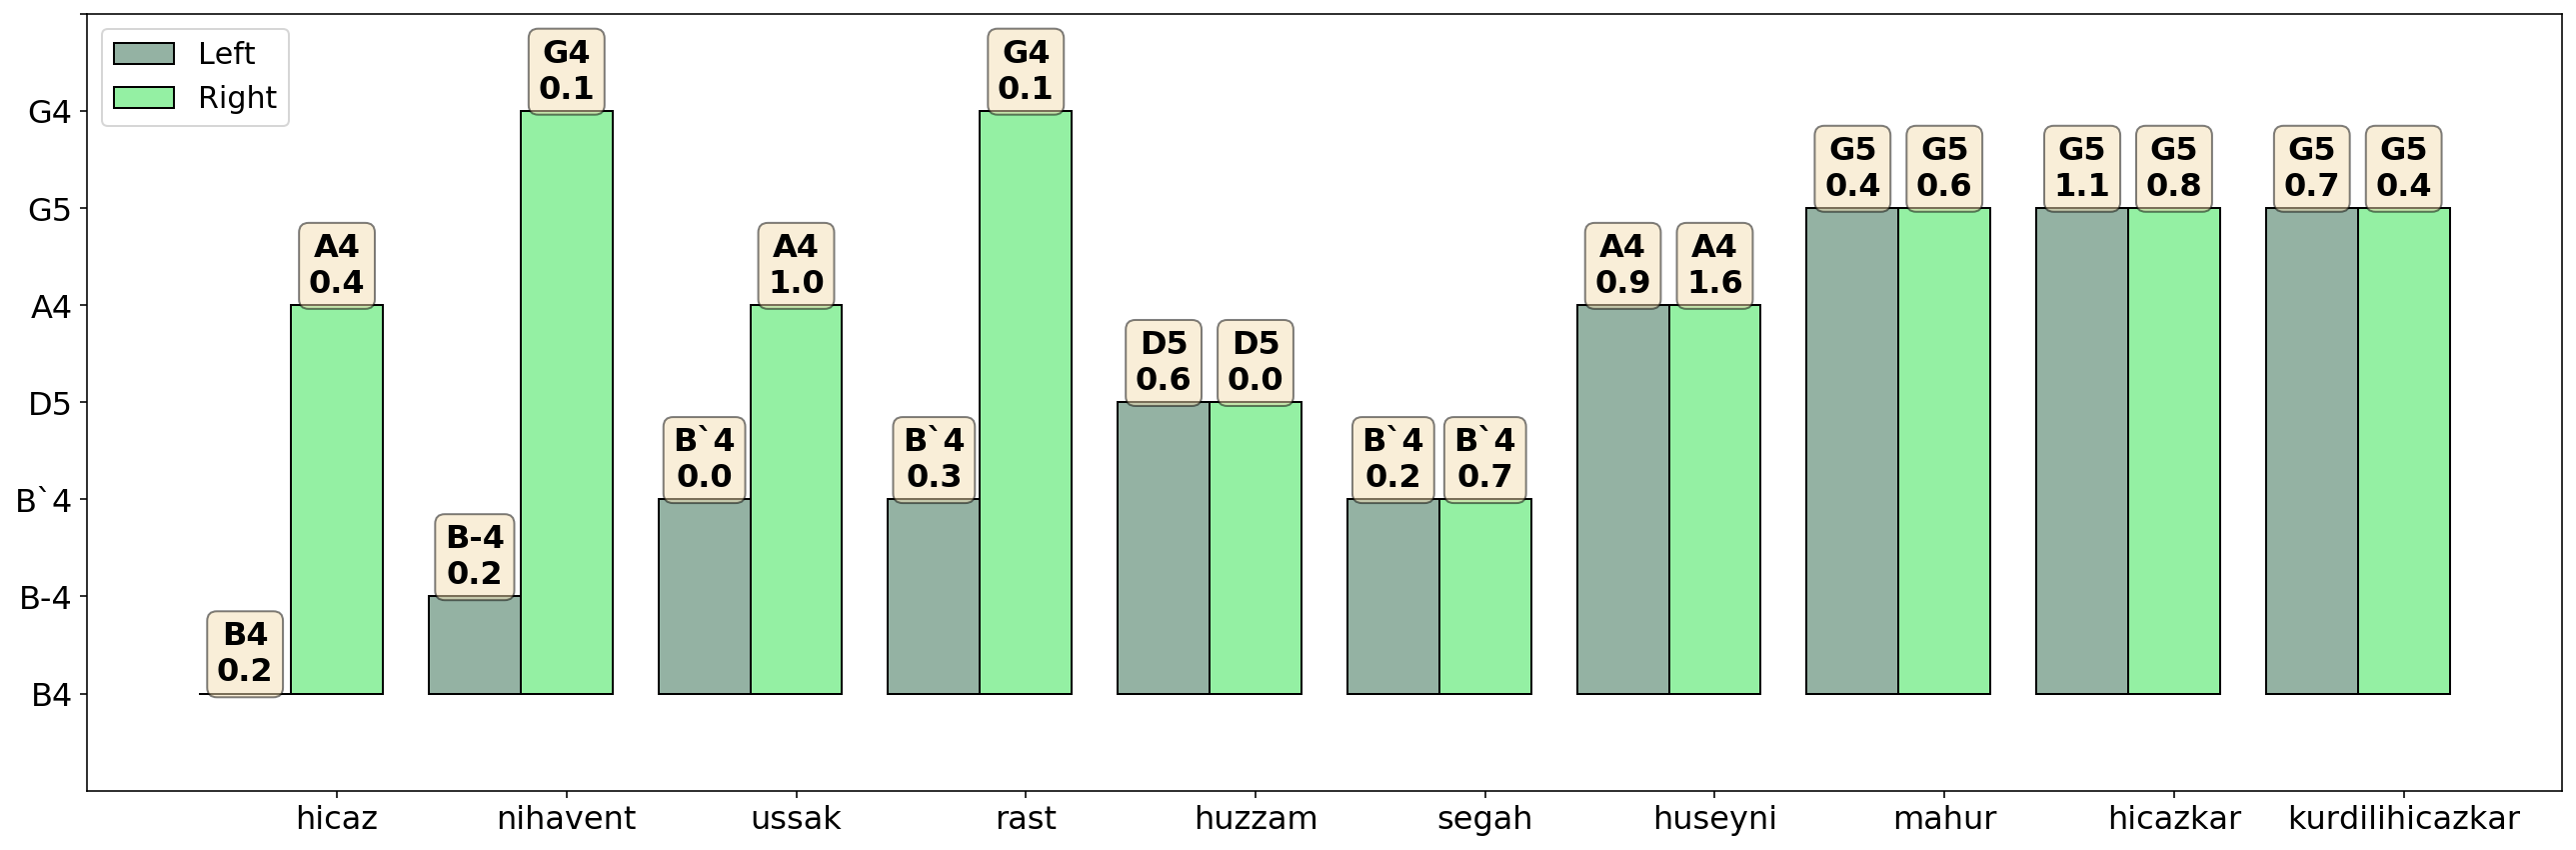

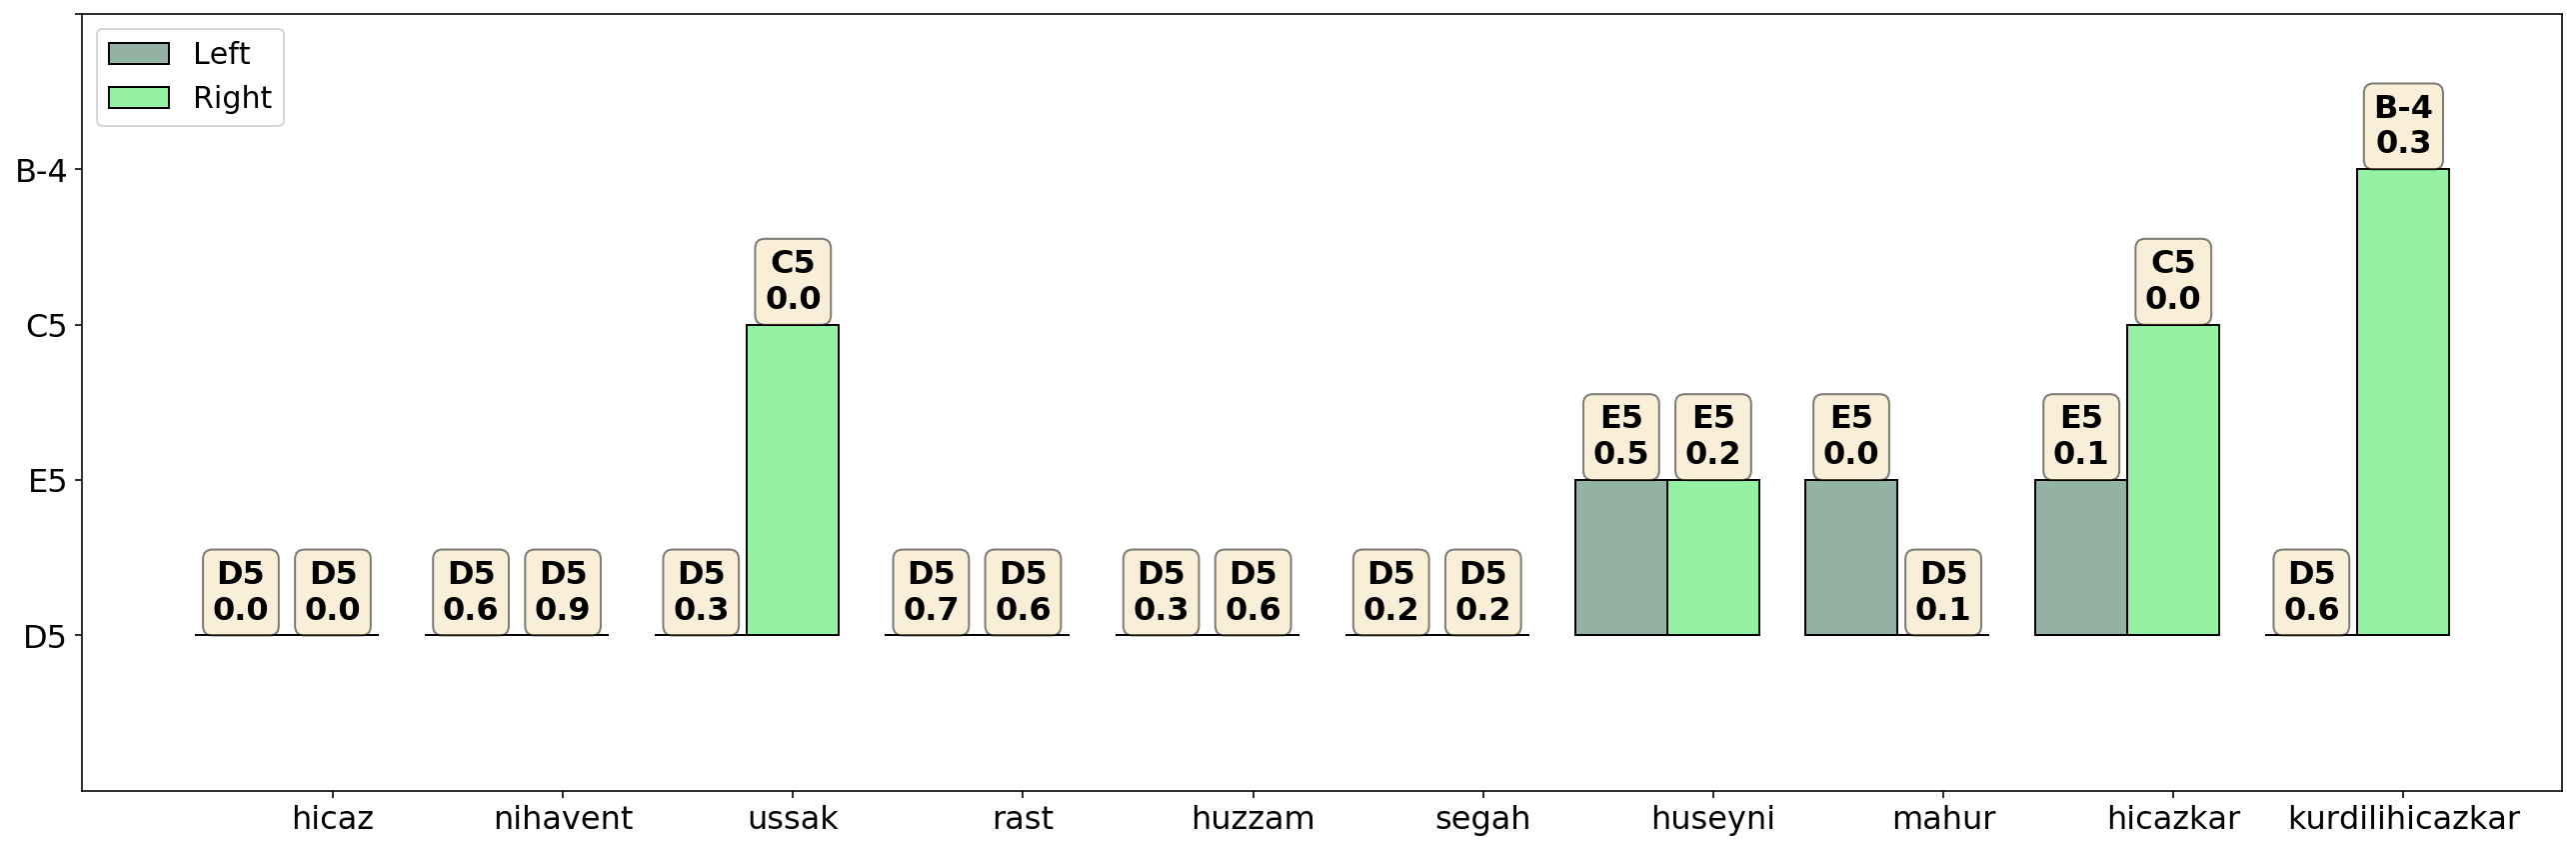

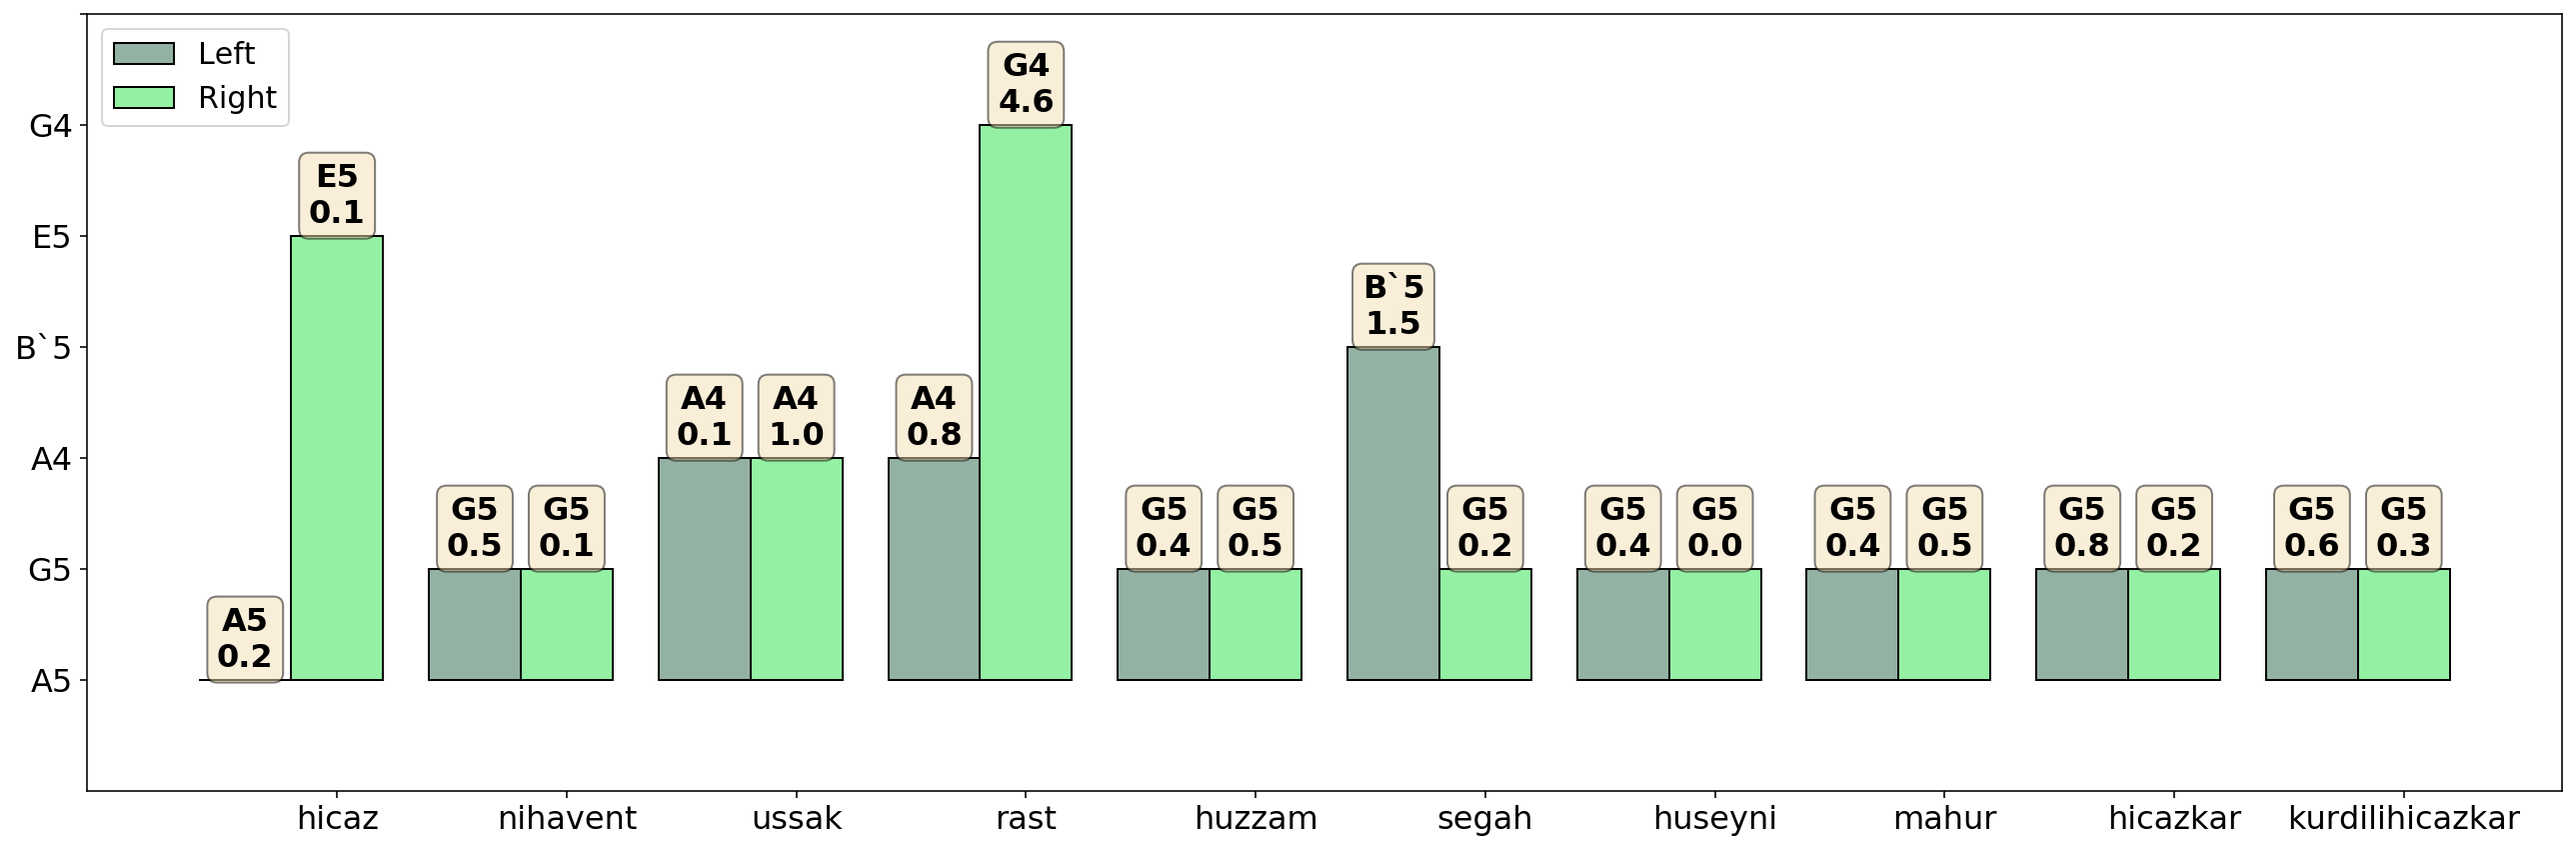

In [21]:
adjacent_notes = [adjacents_notes_tonic,adjacents_notes_domin,adjacents_notes_leadt]
'''
for adj in adjacent_notes:
    for key in adj.keys():
        print(key)
        print(Counter(adj[key]['right']))
        print(Counter(adj[key]['left']))
'''
titles = ['\nAdjacent Notes To Tonic for Makams',
          '\nAdjacent Notes To Dominant for Makams',
          '\nAdjacent Notes To Leading Tone for Makams']
plotAdjacentNotesPerMakam(adjacent_notes,titles,save_name='./approach2_')